This workbook uses data from the supplement to [Quantifying inter-group variability in lactation curve shape and magnitude with the MilkBot® lactation model](https://peerj.com/articles/54/) to demonstrate extraction of data from a csv file in wide format (multiple data points per row). It should work with any of the files in the supplement.

To use it, enter your API key, and the file you would like to examine. You will also need to have the data file available somewhere, and the `milkbot.jl` module at a path specified in the `include`. 

After setting up a struct and functions to translate the input data to the `Lactation` struct of Milkbot module, I read a record from the input data by row number. That data is already fitted, but I refit it using `refitPlot` from the Milkbot module. That includes (from within `refitPlot`) a call to the `fitLactation` function which uses your credentials to send the `Lactation` to the milkbot server for fitting.

`refitPlot` is a tool I use to check performance of the fitting engine with different priors or modifications. It asks the server to return the fitting "path" in addition to the final fit, and each iteration along the path is graphed. It allows you to see how the algorithm stepped to a final answer. You may note a slight difference between the original fit and the refit - most likely because I changed the priors used after the paper was published. This is a Bayesian process, and priors do influence the result as shown by the refitPlot.

Try changing the `r` (row) value in line 58 to graph a different lactation. Then look in `milkbot.jl` for other plots and the functions you can use directly to call the API. You might also want to display the DataFrame `df`. 

If you get a "invalid JSON at byte position 1" error, it may be because the api key you entered is not valid, and the error response returned cannot be parsed into a `Fit`.

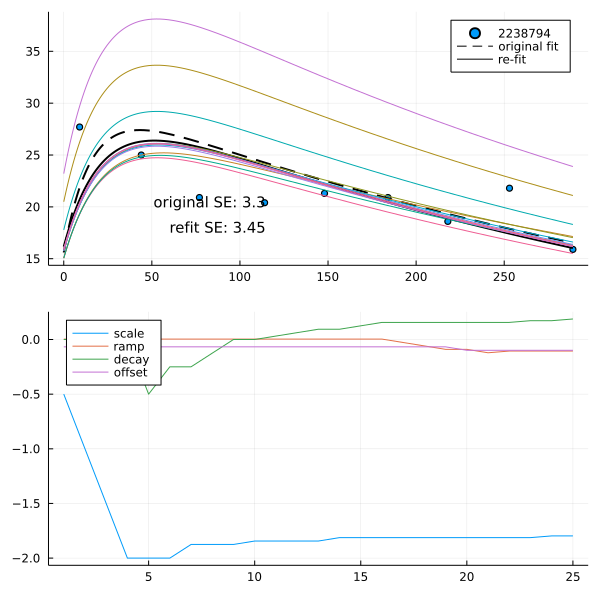

┌ Warning: thread = 1 warning: only found 31 / 33 columns around data row: 1. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 29 / 33 columns around data row: 2. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 29 / 33 columns around data row: 3. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 31 / 33 columns around data row: 4. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 29 / 33 columns around data row: 5. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 29 / 33 columns around 

In [1]:
include("milkbot.jl")
using  .Milkbot, CSV, HTTP, StructTypes,  Plots, DataFrames, JSON3, TensorCast, Setfield

apikey = "<your key here>"  #enter your API key here
file = "supplementalDataS1/Additional file 2.csv" #data file (use pwd() to see your current working directory)

server = "https://milkbot.com/"
cred = Credentials(server, apikey)

const df = CSV.read(file,DataFrame)

#define a structure to match the input file
struct RowType1
    lactkey::Integer
    breed::String
    parity::Integer
    scale::Number
    ramp::Number 
    decay::Number
    offset::Number
    n::Integer
    se::Number
    dim::Vector
    milk::Vector
end

#function to map dataframe fields to the RowType
#we need to lift (un-flatten) the DIM,milk values 
RowType1(d:: DataFrame, r::Integer ) = RowType1(
    d[r,:lactkey], 
    d[r,:Breed],      
    d[r,:Parity],
    d[r,:Scale],
    d[r,:Ramp],
    d[r,:Decay],
    d[r,:Offset],
    d[r,:points],
    d[r,:RMSE],
    filter(!isnothing, map(n -> d[r, "dim$(n)"], 1:9)),
    filter(!isnothing, map(n ->  d[r, "milk$(n)"], 1:9)) 
)
#below used by JSON3
StructTypes.StructType(::Type{Priors}) = StructTypes.Struct()
StructTypes.StructType(::Type{MBParams}) = StructTypes.Struct()
StructTypes.StructType(::Type{Fit}) = StructTypes.Struct()

pr = getPriorsTree(cred) #then cut out Hostein/Parity2/priors below 
jsp = JSON3.read(pr).content.node.priorsTree[1].content.node.priorsTree[2].content.node.priors 
h2priors = JSON3.read(JSON3.write(jsp), Priors) #no PriorsTree struct

lacFromRow(r::RowType1) = begin
    pts = map(i -> MilkPoint(r.dim[i], r.milk[i]) , 1:(min(length(r.dim),length(r.milk))))
    l = Lactation(string(r.lactkey),r.breed,r.parity, pts)
    f = Fit(string(r.lactkey),  MBParams(r.scale,r.ramp,r.decay,r.offset), r.n, r.se, nothing) #no path yet
FittedLactation(l,f)
end

r = RowType1(df,35)
fl = lacFromRow(r)

p = refitPlot(fl, h2priors, cred)
display(p)

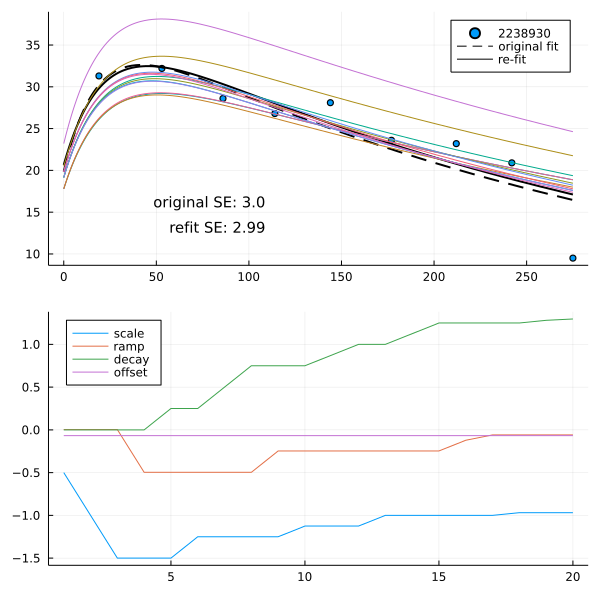

In [2]:
r = RowType1(df,4)
fl = lacFromRow(r)

reFit = JSON3.read(fitLactation(fl.lac, h2priors, cred), Fit) 

p = refitPlot(fl, h2priors, cred)
display(p)

In [3]:
h2priors.means

MBParams(Float16(50.16), Float16(22.75), Float16(0.002184), Float16(-0.7754))